In [1]:
# -*- coding: utf-8 -*-
#   This work is part of the Core Imaging Library (CIL) developed by CCPi 
#   (Collaborative Computational Project in Tomographic Imaging), with 
#   substantial contributions by UKRI-STFC and University of Manchester.

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

#   Copyright 2019 UKRI-STFC, The university of Manchester
#   Authored by:    Ryan Warr (UoM)
#                   Evangelos Papoutsellis (UKRI-STFC)

<h1><center>Hyperspectral CT Reconstruction</center></h1>

<h2><center>Learning Objectives</center></h2>

By the end of this notebook, you will be able to:

- Identify the key differences in building Image/Acquisition Geometries and Operators for hyperspectral datasets 
- Build your own reconstructions using FDK, CGLS and PDHG
- Determine optimum regularisation parameters based on reconstruction method
- Evaluate the effectiveness of each reconstruction routine using spatial and energy profiles.

### Prerequisites:

- Acquisition/Image Geometry, Acquisition Data
- ProjectionOperator
- FDK, CGLS, PDHG, TV
- BlockFramework

### Background:

Conventional X-ray detectors only measure the variable density of objects they pass through, giving no insight into what materials are actually inside. This is because standard detectors measure only the number of photons that arrive at each point on the detector.

For hyperspectral imaging, one can use an energy-sensitive X-ray detector, which measures the energy of every X-ray photon that arrives at each individual pixel. This provides an additional layer of information which can provide important insight on a sample's composition or structure. However, adapted reconstruction routines are required to account for the extra energy-based dimension.

The additional energy dimension is stored as a histogram of energy 'channels', indicating the number of X-ray photons detected by a pixel within a fine energy range. Typically 200+ channels are acquired, however in order to speed up computation time, we will restrict our dataset to just 40 channels, where the dominant energy signals are known to appear.   
  

In [14]:
# Import libraries
from cil.framework import AcquisitionGeometry, BlockDataContainer

from cil.optimisation.algorithms import PDHG, CGLS
from cil.optimisation.operators import BlockOperator, GradientOperator
from cil.optimisation.functions import L2NormSquared, L1Norm, MixedL21Norm, BlockFunction, IndicatorBox

from cil.io import NEXUSDataReader, NEXUSDataWriter

from cil.plugins.astra.processors import FBP
from cil.plugins.astra.operators import ProjectionOperator

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer

import numpy as np                 
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import os

from mpl_toolkits.axes_grid1 import AxesGrid

## Load data using scipy

In [15]:
# Read h5 data file
pathname = os.path.abspath("/mnt/materials/SIRF/Fully3D/CIL/Lizard")
filename = 'Lizard_Sino_100_140.h5'

path = os.path.join(pathname , filename)
arrays = {}

with h5py.File(path, 'r') as f: 
    for k, v in f.items():
        arrays[k] = np.array(v)
    X = arrays['SS'] 
f.close()

# Read Energy-Channel conversion
tmp_energy_channels = sio.loadmat(pathname + "/Energy_axis.mat")
ekeV = tmp_energy_channels['E_axis']
ekeV_crop = ekeV[0][99:139]

The sample we will look at in this notebook is an iodine-stained lizard head. The use of elemental staining is common in biology and medicine, by acting as a contrast agent to provide improved visibility of internal structures for X-ray imaging. Iodine is a popular choice in the clinical and research fields, due to its energy-based properties falling in the typical range for diagnostic X-ray imaging.

The sample was scanned in a lab-based X-ray CT cone-beam system at 50keV, 0.65W, using an energy-sensitive detector to acquire a full 4D dataset. The detector consisted of an 80 x 80 pixel array, with pixel sizes of 250 $\mu$m x 250 $\mu$m. A source-sample distance of 332.0 mm and a sample-detector distance of 270.0 mm gave a geometric magnification of 1.8x, and a reconstructed voxel size of 137$\mu$m. The sample was scanned for 60 projections over a full 360$^{\circ}$ rotation, with 120s exposure time per projection.

A diagram of the style of setup used for spectral imaging is shown below from a paper by [C.K.Egan *et al*, 2015](https://www.nature.com/articles/srep15979#):

<img src="Images/Spectral_Imaging_Geometry.jpg" width=800 height=800 align="center">   


As shown by the diagram, each pixel stores its own energy channel histogram, with characteristic signals such as 'Absorption edges' (caused by photoelectric absorption of X-ray photons by the iodine in our sample) producing sharp rises in signal. These are the key features we look for when analysing spectral data.


<h1><center>Setting up Acquisition/Image Geometry</center></h1>

First we need to setup the geometries based on the acquisition system.
These are currently ordered based on the 4D raw dataset.

Run the code to see the current dimensions.

In [16]:
print(X.shape)

(40, 80, 60, 80)


We can allocate these separately

In [17]:
num_channels = X.shape[0]
vertical = X.shape[1]
num_angles = X.shape[2]
horizontal = X.shape[3]

We set the angles used based on the parameters chosen for data acquisition. An offset is also applied (this just gives us the freedom to adjust the rotation of our reconstructed images).

In [18]:
angles = np.linspace(-180-160,180-160,num_angles,endpoint=False)*np.pi/180

## 4D Acquisition and Image Geometries

We encode all this information into `AcquisitionGeometry` and `ImageGeometry`. We first define the scan geometry parameters, including source-sample-detector distances. These are then used to define our `AcquisitionGeometry`. See **Week1/00_CIL_geometry.ipynb** for more information.

In [19]:
# Define the system scan geometry and detector parameters
distance_source_center = 332.0  # [mm]
distance_center_detector = 270.0  # [mm]
detector_pixel_size = 0.250  # [mm]

In [20]:
# Define acquisition geometry from the detector system acquisition settings
# with reordering of the dimension labels to match the raw data
ag = AcquisitionGeometry.create_Cone3D(source_position = [0,-distance_source_center,0],
                                       detector_position = [0,distance_center_detector,0])\
                                     .set_panel([horizontal,vertical],[detector_pixel_size,detector_pixel_size])\
                                     .set_channels(num_channels)\
                                     .set_angles(-angles,angle_unit="radian")\
                                     .set_labels(['channel', 'vertical', 'angle', 'horizontal'])

# Create the 4D acquisition data
data = ag.allocate()
data.fill(X)

## Show acquisition geometry

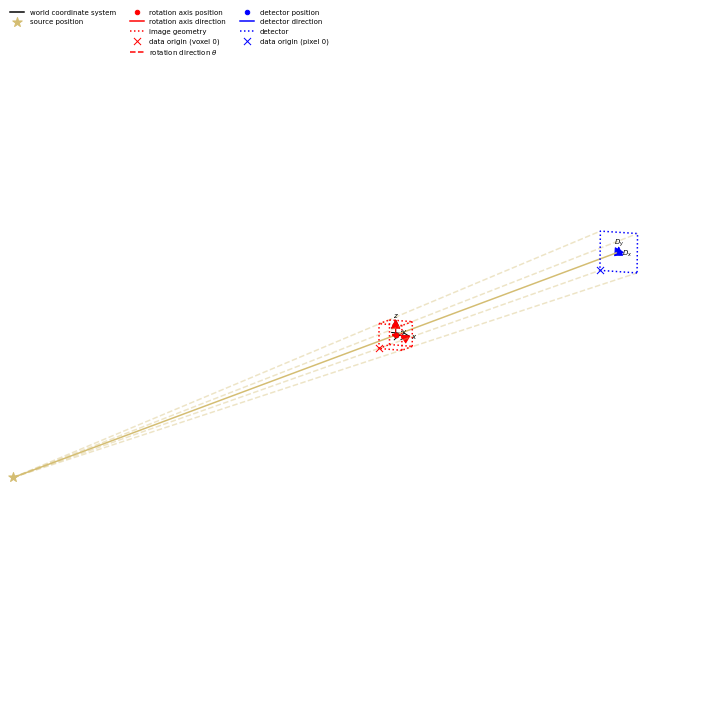

In [21]:
show_geometry(ag, view_distance = 4.5, elevation=10, azimuthal=-65, figsize=(10,10))

In [22]:
print(data)

Number of dimensions: 4
Shape: (40, 80, 60, 80)
Axis labels: ('channel', 'vertical', 'angle', 'horizontal')



Get the `ImageGeometry` directly from the `AcquisitionGeometry` using `ig = ag.get_ImageGeometry()`

In [23]:
ig = ag.get_ImageGeometry()

We can use an interactive image slicer `islicer` to provide a visualisation of the `AcquisitionData` in any dimension below. Simply by taking a data slice in a particular dimension, we can then visualise the data in any other given dimension.

Run the code below to see three such examples:

1) Projection radiographs for each of the 60 rotation angles acquired in a single channel

2) The sinogram for each energy channel for the central slice

3) The spectral signals acquired in each energy channel for a single projection angle  


**Note: You can adjust the look of your reconstructions by varying certain parameters**  
 - by removing `cmap`, you return to the default colour map of 'gray'
 - the default scaling runs through the full data range, set initial limits using e.g. `minmax = (0.0 , 2.0)`


In [24]:
islicer(data.get_slice(channel=20), direction='angle', title = 'Projection Angle', cmap='inferno',minmax=(0.0,2.0))

interactive(children=(IntSlider(value=30, continuous_update=False, description='angle', max=59), FloatRangeSli…

IntSlider(value=30, continuous_update=False, description='angle', max=59)

In [25]:
islicer(data.get_slice(vertical=40), direction='channel', title = 'Sinogram Channel', cmap='inferno',minmax=(0.0,1.0))

interactive(children=(IntSlider(value=20, continuous_update=False, description='channel', max=39), FloatRangeS…

IntSlider(value=20, continuous_update=False, description='channel', max=39)

In [26]:
islicer(data.get_slice(angle=42), direction='channel', title = 'Channel', cmap='inferno',minmax=(0.0,2.0))

interactive(children=(IntSlider(value=20, continuous_update=False, description='channel', max=39), FloatRangeS…

IntSlider(value=20, continuous_update=False, description='channel', max=39)

We setup the tomography operator for 3D hyperspectral data using the `AcquisitionGeometry` and `ImageGeometry`
<a id='A3DMC' ></a>

In [27]:
ag3D = ag.get_slice(channel=0)
ig3D = ag3D.get_ImageGeometry()

# FDK Reconstruction

One of the simplest, and most common, means of image reconstruction for X-ray CT is the use of Filtered BackProjection (FBP). In the case of many lab-based X-ray sources, which utilise a cone-beam rather than parallel- or fan-beams, we use a specific case of FBP: The [Feldkamp-Davis-Kress (FDK)](https://www.osapublishing.org/josaa/abstract.cfm?uri=josaa-1-6-612) algorithm.

The function `FBP` is capable of handling reconstructions for both parallel-beam and cone-beam geometries in 2D and 3D. To apply this to 4D data, we loop over all channels in our dataset, performing a 3D FDK reconstruction for each channel, and fill this into a 4D (3D + Channels) image data array.

In [28]:
# allocate space for the FBP_4D recon
FBP_recon_4D = ig.allocate()

# FBP reconstruction per channel
for i in range(ig.channels):
    
    FBP_recon_3D = FBP(ig3D, ag3D, 'gpu')(data.get_slice(channel=i))
    FBP_recon_4D.fill(FBP_recon_3D, channel=i)
    
    print("Finish FBP recon for channel {}".format(i), end='\r')
    
print("\nFDK Reconstruction Complete!")

Finish FBP recon for channel 39
FDK Reconstruction Complete!


We can use the `show2D` function to observe a 2D reconstructed slice of our 4D volume. Using the `slice_list` argument, we can set specific values for each dimension to choose what reconstructed slice we wish to see. Here we look at a single slice (35) in the vertical ('axial') plane, shown for a single energy channel (20). As expected, the data is quite noisy, with poor feature definition in the majority of the soft tissue.

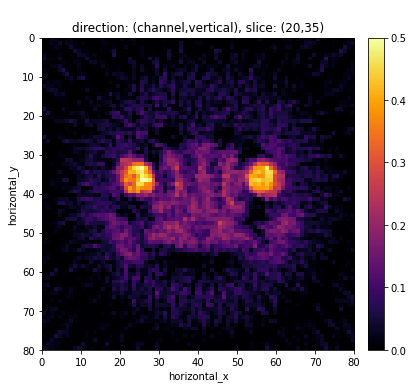

In [29]:
show2D(FBP_recon_4D,
       slice_list=[[("channel",20),("vertical",35)]], 
       cmap="inferno", origin="upper", 
       fix_range=(0,0.5), size=(10,10))

While some features of the lizard head can be seen in the reconstructed images, much of the signal is shrouded by noise.  
In the next section, we will explore the first iterative algorithm - CGLS.

## Running the CGLS algorithm on a 4D dataset

As the next step, we will begin with a standard CGLS algorithm, applied to our 4D dataset

This is very simple to set up, we simply require a `ProjectionOperator`, A, which we can create using our `AcquisitionGeometry` and `ImageGeometry`. For a 4D dataset, we require the use of `gpu`.

After initialising the reconstruction with `x0 = ig.allocate()`, we can set up our CGLS algorithm.

Let's test the CGLS algorithm for just 10 iterations.

In [30]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, 'gpu')

# Initialise 
x0 = ig.allocate()
cgls = CGLS(initial = x0, operator = A, data = data,
               max_iteration = 10, update_objective_interval = 2)
cgls.run(10,verbose=1)
cgls_10 = cgls.solution

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          2.92650e+06
        2         10         0.465          1.05120e+05
        4         10         0.463          8.15727e+04
        6         10         0.466          7.30213e+04
        8         10         0.466          6.75842e+04
       10         10         0.465          6.43240e+04
-------------------------------------------------------
       10         10         0.465          6.43240e+04
Stop criterion has been reached.



We can evaluate the quality of our reconstruction, by looking at different spatial planes, as well as varying the single energy channel we observe. We access these by selecting values from our reconstruction with `cgls_10.as_array()[channel_num,slice_z,slice_y,slice_x]`.

Run the code below to see reconstructions for the 10th, 20th and 30th channel in our truncated dataset, with the X-ray energies these correspond to, for three different spatial planes (Axial, Coronal, Sagittal). As you will see, the attenuation level rises sharply between the 10th and 20th energy channel, indicative of a spectral marker (absorption edge) being crossed.

## Show CGLS reconstruction with 10 iterations at different energy channels and views: Axial, Coronal, Sagittal

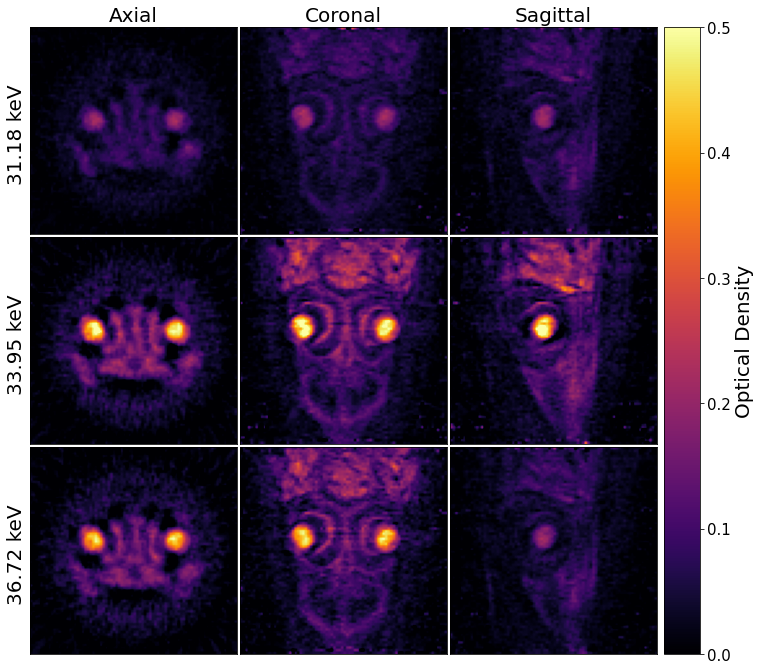

In [31]:
recons = [cgls_10.get_slice(channel=10, vertical=35), cgls_10.get_slice(channel=10, horizontal_y=35), cgls_10.get_slice(channel=10, horizontal_x=25),\
          cgls_10.get_slice(channel=20, vertical=35), cgls_10.get_slice(channel=20, horizontal_y=35), cgls_10.get_slice(channel=20, horizontal_x=25),\
          cgls_10.get_slice(channel=30, vertical=35), cgls_10.get_slice(channel=30, horizontal_y=35), cgls_10.get_slice(channel=0, horizontal_x=25)]
    

labels_x = ["Axial", "Coronal", "Sagittal"]
labels_y = ["{:.2f} keV ".format(ekeV_crop[10]),
            "{:.2f} keV ".format(ekeV_crop[20]),
            "{:.2f} keV ".format(ekeV_crop[30])]

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(12, 14))

grid = AxesGrid(fig, 111,
                nrows_ncols=(3, 3),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_size = 0.5,
                cbar_pad=0.1
                )
k = 0

for ax in grid:
    im = ax.imshow(recons[k].as_array(), cmap="inferno", vmin = 0.0, vmax = 0.5)   
    
    if k==0:
        ax.set_title(labels_x[0],fontsize=20)
        ax.set_ylabel(labels_y[0],fontsize=20)
    if k==1:
        ax.set_title(labels_x[1],fontsize=20)  
    if k==2:
        ax.set_title(labels_x[2],fontsize=20)  
    if k==3:
         ax.set_ylabel(labels_y[1],fontsize=20)  
    if k==6:
         ax.set_ylabel(labels_y[2],fontsize=20) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

plt.colorbar(im, cax=grid.cbar_axes[0]).set_label(label='Optical Density', size = 20)

Let us now run the reconstruction for 30 iterations, and compare the two results in the cells below.

In [32]:
cgls = CGLS(initial = x0, operator = A, data = data,
               max_iteration = 30, update_objective_interval = 10)
cgls.run(verbose=1)
cgls_30 = cgls.solution

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         30         0.000          2.92650e+06
       10         30         0.481          6.43240e+04
       20         30         0.479          5.70694e+04
       30         30         0.479          5.40342e+04
-------------------------------------------------------
       30         30         0.479          5.40342e+04
Stop criterion has been reached.



## Show CGLS reconstruction 10 iterations vs 30 iterations at the 20th energy channel and views: Axial, Coronal, Sagittal

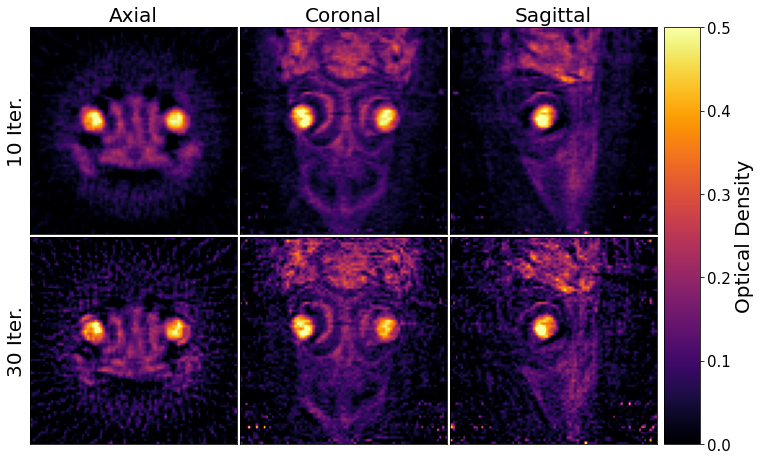

In [33]:
recons = [cgls_10.get_slice(channel=20, vertical=35), cgls_10.get_slice(channel=20, horizontal_y=35), cgls_10.get_slice(channel=20, horizontal_x=25),\
          cgls_30.get_slice(channel=20, vertical=35), cgls_30.get_slice(channel=20, horizontal_y=35), cgls_30.get_slice(channel=20, horizontal_x=25)]  

labels_x = ["Axial", "Coronal", "Sagittal"]
labels_y = ["10 Iter.","30 Iter."]

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(12, 14))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 3),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_size = 0.5,
                cbar_pad=0.1
                )

k = 0

for ax in grid:
    im = ax.imshow(recons[k].as_array(), cmap="inferno", vmin = 0.0, vmax = 0.5)   
    
    if k==0:
        ax.set_title(labels_x[0],fontsize=20)
        ax.set_ylabel(labels_y[0],fontsize=20)
    if k==1:
        ax.set_title(labels_x[1],fontsize=20)  
    if k==2:
        ax.set_title(labels_x[2],fontsize=20)  
    if k==3:
        ax.set_ylabel(labels_y[1],fontsize=20)  
    
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

plt.colorbar(im, cax=grid.cbar_axes[0]).set_label(label='Optical Density', size = 20)

These images highlight the instability of a basic CGLS algorithm, where the **number of iterations** effectively acts as the algorithm's **regularisation parameter**. As a result, too many iterations leads to a divergence from an optimum solution, with only additional noise being contributed beyond a certain point. 

Next we will look at an extension of the CGLS algorithm, where we now apply a specific regularisation factor. Here, we will use **Tikhonov** regularisation, and show how it can be applied to improve reconstruction quality in both the spatial and spectral dimensions.

## Tikhonov Regularisation for CGLS

Here we will expand upon what you learned about BlockFrameworks. In particular, we will cover both `BlockOperators` and `BlockDataContainers`, which were covered in **Week2/02_tikhonov_block_framework**.

Below gives a brief definition of each type:

`BlockDataContainer` holds datacontainers as a column vector.

`BlockOperator` is a matrix of operators.

### Setting up "Regularised CGLS"

For our regularisation, we wish to solve:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{\alpha \nabla}{A} u - \binom{0}{g}\end{Vmatrix}^2_2$$
With the definitions:

$\tilde{A} = \binom{\alpha \nabla}{A} \quad\Longleftrightarrow\quad$ `BlockOperator(alpha*Grad(ig),A)`  
(where $\alpha$ is the regularisation parameter)

$\tilde{g} = \binom{0}{g} \quad\Longleftrightarrow\quad$ `BlockDataContainer(Grad.domain.allocate(0),data)`

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{g}\end{Vmatrix}^2_2$$
and being a least squares problem, it can be solved using CGLS with $\tilde{A}$ as operator and $\tilde{g}$ as data.

### Build `BlockOperator`, $\tilde{A} = \binom{\alpha \nabla}{A}$

Using the 2D hyperspectral data and geometry constructed above, build a `BlockOperator`, $\tilde{A}$, applying a "Space-Channel" correlation. This means that our regularisation will be applied across both the spatial and spectral domains.  
Choose a regularisation value around $\alpha$ = 0.1 as a starting point.
<a id='Choosing_alpha'></a>

In [34]:
# Set up operators for BlockOperator
Grad = GradientOperator(ig, correlation='SpaceChannels')

alpha = 0.1
A_block = BlockOperator(alpha*Grad,A)

Initialised GradientOperator with C backend running with  3  threads


### Build `BlockDataContainer`, $\tilde{g} = \binom{0}{g}$

Next build a `BlockDataContainer`, $\tilde{g}$, containing an array with the range of the regularising operator, $\alpha \nabla$, and our `AcquisitionData` (`data`).

In [35]:
# Create BlockDataContainer
g_block = BlockDataContainer(Grad.domain.allocate(0),data)

### Initialise and Run

Now we can initialise the `BlockOperator` and run the algorithm for 10 iterations.

In [36]:
# Initialise the BlockOperator
x0 = ig.allocate(0)

# Setup and run the regularised CGLS algorithm

cgls_reg = CGLS(x_init = x0, operator = A_block, data = g_block,
                max_iteration = 100, update_objective_interval = 2)
cgls_reg.run(10, verbose=1)
cgls_reg_10 = cgls_reg.solution

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          2.92650e+06
        2        100         0.828          1.05607e+05
        4        100         0.832          8.34085e+04
        6        100         0.828          7.69687e+04
        8        100         0.827          7.48670e+04
       10        100         0.825          7.44018e+04
-------------------------------------------------------
       10        100         0.825          7.44018e+04
Stop criterion has been reached.



Use `show2D` in the cell below to compare 10 iterations of the basic CGLS algorithm, with the 10 iteration result of CGLS with Tikhonov regularisation.

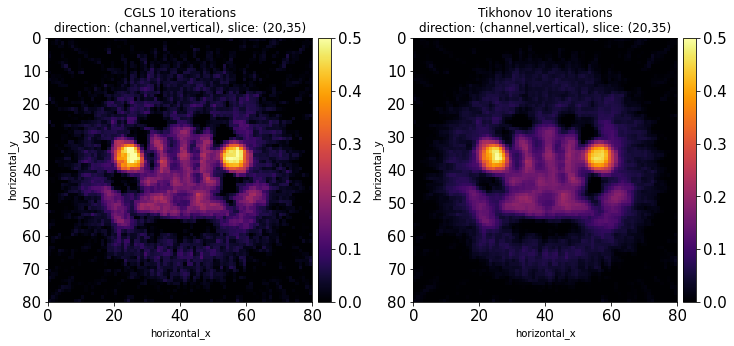

In [37]:
show2D([cgls_10,cgls_reg_10],
       slice_list=[[("channel",20),("vertical",35)]]*2, 
       cmap="inferno", origin="upper",title=["CGLS 10 iterations", "Tikhonov 10 iterations"],
       fix_range=(0,0.5), size=(10,10))

We can see that the main effect of the **Tikhonov** regularisation is to smooth the fetaures, such that the noise in the image is suppressed. However this is still not perfect for restoring strong feature definition.

In the next section, we will look at a different algorithm: Primal-Dual Hybrid Gradient (PDHG), combined with a Total Variation (TV) regularising factor, to see if this improves our reconstructed data quality any further.

## Total Variation Regularisation in 4D Volume using PDHG

The PDHG algorithm and Total Variation regularisation were covered extensively in **Week2/03_PDHG** notebook, but below gives a brief recap of the basics behind each.

### Recap on PDHG

PDHG aims to solve problems of the form:

$$ \begin{equation} \min_{u} \mathcal{F}(K u) + \mathcal{G}(u) \label{min_problem} \end{equation} $$

In order to setup and run PDHG, we need to define the following:

 - The operator $K$.
 - The function $\mathcal{F}$ and $\mathcal{G}$.
 - Step-sizes $\sigma$ and $\tau$ such that $\sigma\tau\|K\|^{2}<1$.
 
Then we can setup PDHG:

`pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iteration = maxiter)`




### Applying Total Variation Regularisation

<a id='TV_setup'></a>

For this notebook, we will be applying Total Variation (TV) regularisation to our PDHG algorithm. TV is a non-smooth regulariser, 

$$ \underset{u}{\operatorname{argmin}} \alpha\,\mathrm{TV}(u) + \frac{1}{2} \| \mathcal{A} u - g\|^{2}_{2} + \mathbb{I}_{\{u>0\}}(u) $$

where,

- The Total Variation is taken as a `MixedL21Norm()`, such that $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$  
- $g$ is the Acquisition data obtained from the detector  
- $\mathcal{A}$ is the projection operator ( Radon transform ) that maps from an image-space to an acquisition space, i.e.,  
$\mathcal{A} : X \rightarrow Y$.  
- $\alpha$ is the regularising parameter that measures a trade-off between the fidelity and the regulariser terms  
- $\mathbb{I}_{\{u>0\}}(u) : = 
\begin{cases}
0,\quad u>0\\
\infty,\quad \mbox{otherwise}
\quad
\end{cases},\quad
$ is a positivity constraint for the minimiser $u$.

## Setting up PDHG for TV

We define K as a `BlockOperator`, containing the Gradient and Projection operator:

$$ K = 
\begin{bmatrix}
\nabla\\
A
\end{bmatrix}
$$
K = `BlockOperator(Grad, A)`

The function $\mathcal{F}$, is a `BlockFunction` with

a function $\alpha\|\cdot\|_{2,1}\quad\Longleftrightarrow\quad$ `MixedL21Norm()` term that represents the Total variation regularisation ,

a function $\|\cdot -g \|_{2}^{2}\quad\Longleftrightarrow\quad$ `L2NormSquared(data)` term that represents the data fitting.

Hence, $\mathcal{F} = [f_{1}, f_{2}] \quad\Longleftrightarrow\quad $ `F = BlockFunction(MixedL21Norm(), L2NormSquared(data))`

Finally, we have the function $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u) \quad\Longleftrightarrow\quad$ `G = IndicatorBox(lower=0)`

Again, we can verify that with the above setting we can express our problem into this form, for $x=u$

$$ \begin{align} \underset{u}{\operatorname{argmin}}\alpha\|\nabla u\|_{2,1} + \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \mathbb{I}_{\{u>0\}}(u) \\= \underset{u}{\operatorname{argmin}} f_{1}(\nabla u) + f_{2}(\mathcal{A}u) + \mathbb{I}_{\{u>0\}}(u) \\ = \underset{u}{\operatorname{argmin}} \mathcal{F}( \begin{bmatrix} \nabla \\ \mathcal{A} \end{bmatrix}u) + \mathbb{I}_{\{u>0\}}(u)\\ = \underset{u}{\operatorname{argmin}} \mathcal{F}(Ku) + \mathcal{G}(u)\\ = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) \end{align} $$

We will start by building our `BlockOperator`, K. This requires a `GradientOperator`, which to start with we will create with only a _Space_ correlation, therefore only applying across the spatial dimensions.

In [38]:
# The operator K is a Block Operator that contains the gradient and the tomography operator (as created previously)
Grad = GradientOperator(ig, correlation="Space")

# Set up a BlockOperator K
K = BlockOperator(Grad,A) 

Initialised GradientOperator with numpy backend


/opt/SIRF-SuperBuild/INSTALL/python/cil/optimisation/operators/GradientOperator.py:84: UserWarning: Warning: correlation='Space' on multi-channel dataset will use `numpy` backend
  warnings.warn("Warning: correlation='Space' on multi-channel dataset will use `numpy` backend")


$\mathcal{F}$ is a `BlockFunction` of a fidelity term and our TV regularising term:

- $f_{1}$ = $\alpha\|\cdot\|_{2,1}\quad\Longleftrightarrow\quad$ `MixedL21Norm()` term that represents the Total variation regularisation ,

- $f_{2}$ = $\|\cdot -g \|_{2}^{2}\quad\Longleftrightarrow\quad$ `L2NormSquared(data)` term that represents the data fitting.

Therefore as $f_{1}$ and $f_{2}$ act on each element of $K$, we end up with  
$$ \mathcal{F}(Ku) = \mathcal{F}(
\begin{bmatrix}
\nabla u \\
A u
\end{bmatrix}) = ( f_{1}(\nabla u), f_{2}(Au) ) $$

Our regularising parameter, $\alpha$ adjusts the wighting of the TV regularisation. THe greater impact you want the regularisation to have on your data, the larger you make $\alpha$. Typically, the optimum value will vary for each dataset, and some trial and error may be required to find the best result.  
Let us start here by using $\alpha$ = 0.004, and then build our `BlockFunction` as described above.

In [39]:
# Select the weighting of the regularising parameter, alpha
alpha = 0.004

# List of BlockFunctions
f1 = alpha * MixedL21Norm()  
f2 = 0.5 * L2NormSquared(b = data) 

F = BlockFunction(f1, f2) 

Next, we have our positivity constraint function $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u) \quad\Longleftrightarrow\quad$ `G = IndicatorBox(lower=0)`.

In [40]:
G = IndicatorBox(lower = 0)  

Finally, we compute the operator norm of $K$ (`normK = K.norm()`), and set our step sizes, $\sigma$ and $\tau$.

In [41]:
# Compute the operator norm for K
normK = K.norm()

# Define the step sizes sigma and tau
sigma = 1./normK
tau = 1./normK

Now we can setup and run the PDHG algorithm. Here it will run for 100 iterations.

Due to the increased complexity of the algorithm, combined with the reconstruction of a 4D dataset, the runtime for 100 iterations alone will be around **3 minutes**. However, we may require many more than 100 iterations to reach an optimum solution. Further, we may wish to reconstruct hundreds of energy channels, rather than just the 40 we use here.

Therefore, consideration must be taken on the number of iterations you perform based on your choice of algorithm and size of your dataset.

In the following cells, we have also provided a final reconstruction after 1000 iterations of PDHG TV, which required around 30 minutes of runtime.

In [42]:
PDHG_TV = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma,
            max_iteration = 100, update_objective_interval = 25)
PDHG_TV.run(verbose=1)
PDHG_TV_100_Sp = PDHG_TV.solution

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.46325e+06


/opt/SIRF-SuperBuild/INSTALL/python/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


       25        100         1.851          5.87979e+04
       50        100         1.840          4.39805e+04
       75        100         1.834          4.26494e+04
      100        100         1.829          4.21751e+04
-------------------------------------------------------
      100        100         1.829          4.21751e+04
Stop criterion has been reached.



Below, we directly compare the reconstructions of FDK with PDHG TV. As you will see, even at 100 iterations, we get a reasonable reconstructed volume, with already much improved noise suppression compared to the FDK result.

## Show FBP reconstruction vs PDHG TV reconstruction with no regularisation on channels

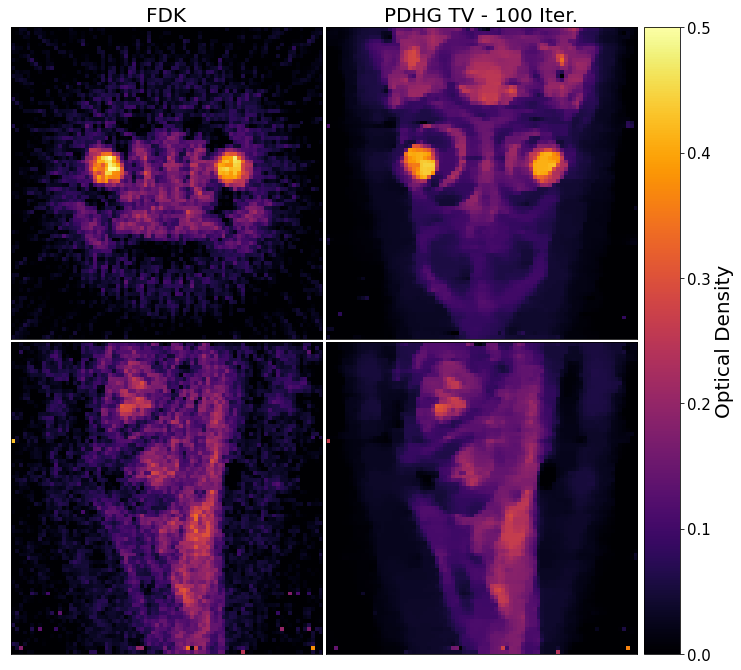

In [43]:
recons = [FBP_recon_4D.get_slice(channel=20, vertical=35), PDHG_TV_100_Sp.get_slice(channel=20, horizontal_y=35),\
          FBP_recon_4D.get_slice(channel=20, horizontal_x=35), PDHG_TV_100_Sp.get_slice(channel=20, horizontal_x=35)]

labels_text = ["FDK", "PDHG TV - 100 Iter."]

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(12, 14))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_size = 0.5,
                cbar_pad=0.1
                )

k = 0

for ax in grid:
    im = ax.imshow(recons[k].as_array(), cmap="inferno", vmin = 0.0, vmax = 0.5)   
    
    if k==0:
        ax.set_title(labels_text[0],fontsize=20)
    if k==1:
        ax.set_title(labels_text[1],fontsize=20)  
    
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

plt.colorbar(im, cax=grid.cbar_axes[0]).set_label(label='Optical Density', size = 20)

###  PDHG TV: 1000 Iterations

You may notice that, for 100 iterations, the PDHG TV result looks slightly __blocky__ in places, despite significant noise suppression. This may be because 100 iterations is insufficient for convergence, therefore we include below a reconstructed dataset after 1000 iterations, stored as a Nexus (`.nxs`) file.

We load in the 1000 iteration result using the `NEXUSDataReader()`. We can now directly compare this result to all our previous reconstructions, including our Tikhonov CGLS result, and the PDHG TV result for 100 iterations.

As you can see, 1000 iterations was sufficient for convergence of the PDHG TV reconstruction. We now see smoothing across all spatial features, reducing all noise such that boundaries of soft tissue features are more clealy defined. In particular, the noisy __haze__ around the main soft tissue is considerably suppressed.

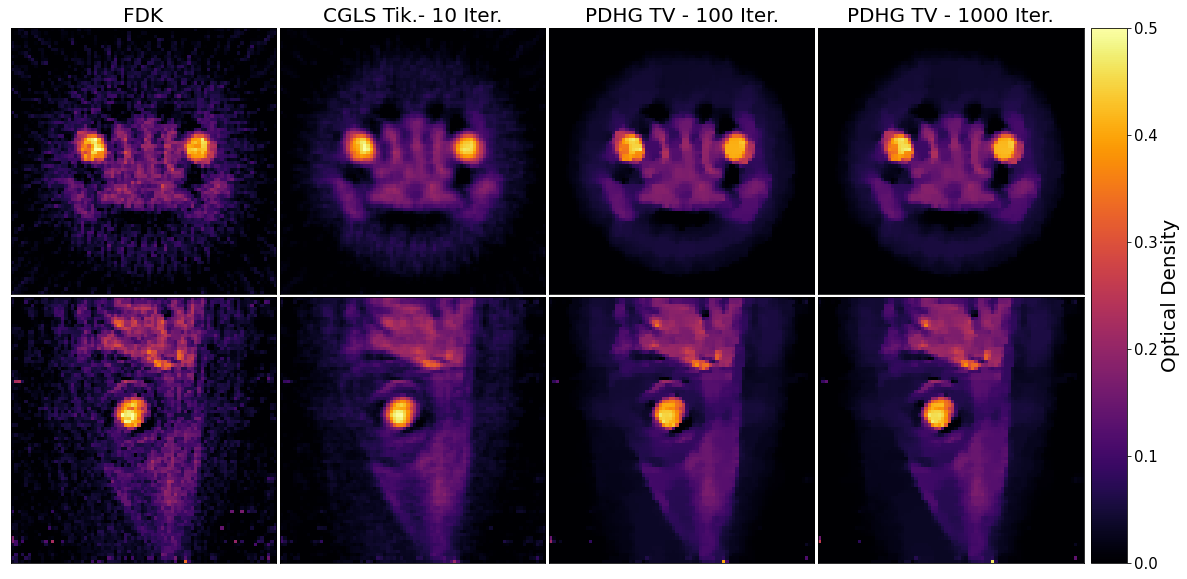

In [44]:
reader = NEXUSDataReader(file_name = "/mnt/materials/SIRF/Fully3D/CIL/Lizard/PDHG_TV_1000_Sp_alpha_0.004.nxs")
PDHG_TV_1000_Sp = reader.read()

recons = [FBP_recon_4D.get_slice(channel=20, vertical=35), cgls_reg_10.get_slice(channel=20, vertical=35),\
          PDHG_TV_100_Sp.get_slice(channel=20, vertical=35), PDHG_TV_1000_Sp.get_slice(channel=20, vertical=35),\
          FBP_recon_4D.get_slice(channel=20, horizontal_x=25), cgls_reg_10.get_slice(channel=20, horizontal_x=25),\
          PDHG_TV_100_Sp.get_slice(channel=20, horizontal_x=25), PDHG_TV_1000_Sp.get_slice(channel=20, horizontal_x=25)]

labels_text = ["FDK","CGLS Tik.- 10 Iter.","PDHG TV - 100 Iter.", "PDHG TV - 1000 Iter."]

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 14))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 4),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_size = 0.5,
                cbar_pad=0.1
                )

k = 0

for ax in grid:
    im = ax.imshow(recons[k].as_array(), cmap="inferno", vmin = 0.0, vmax = 0.5)   
    
    if k==0:
        ax.set_title(labels_text[0],fontsize=20)
    if k==1:
        ax.set_title(labels_text[1],fontsize=20)  
    if k==2:
        ax.set_title(labels_text[2],fontsize=20)      
    if k==3:
        ax.set_title(labels_text[3],fontsize=20) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

plt.colorbar(im, cax=grid.cbar_axes[0]).set_label(label='Optical Density', size = 20)

## Exercise: Set up PDHG with Space-Channel TV Regularisation

We can make some adjustments to our framework to see how these affect the reconstruction.
Our gradient component is capable of smoothing our reconstruction both in the spatial domain, but also in the energy domain, by using neighbouring channels to aid the iterative reconstruction process. We will now test this by setting up PDHG with a Space-Channel TV regularisation.

**Step 1)** Adjust the `GradientOperator` to correlate in both the spatial and spectral domains. Then build your `BlockOperator` K using the `ProjectionOperator` we created earlier for our CGLS reconstruction.

Hint: For TV regularisation, we have the ability to split our regularisation, such that we can adjust the weighting of TV for the spatial and spectral dimensions separately. If you want to do this, add a third argument to your `GradientOperator` called `split=True`.

In [45]:
# Adjust correlation of gradient component
Grad = GradientOperator(ig, correlation = "SpaceChannels", split=True)

# Construct new BlockOperator
K = BlockOperator(Grad, A)

Initialised GradientOperator with C backend running with  3  threads


**Step 2)** Set the regularisation parameters.

If you decided to split your TV regularisation, then now instead of **one** parameter, we now need to create **two**, $\alpha$ and $\beta$, which will act on the spatial and spectral domains respectively.

For our original PDHG reconstruction, our $\alpha$ parameter was:  
$\alpha$ = 0.004.

Now that we have two parameters, $\alpha$ across the spatial domain and $\beta$ across the energy domain, you can try different combinations, for example:  
$\alpha$ = 0.003,  
$\beta$ = 0.5 

In [46]:
# Define regularising parameter alpha
alpha = 0.003
beta = 0.5

**Step 3)** Build the `BlockFunction`

Previously our `BlockFunction` contained two terms: the TV regularisation, and the data fitting. As our TV term is now split, we must build this term as a `BlockFunction` first, combining the spatial and spectral regularisation elements, before combining this with our data fitting term.

Our first term will now look like the following:

$$ \mathcal{f_{1}} = \begin{bmatrix}
\beta\|\cdot\|_{1} \\
\alpha\|\cdot\|_{2,1}
\end{bmatrix}
$$ 
So we use the `L1Norm()` for our $\beta$ parameter, and the `MixedL21Norm()` for our $\alpha$ parameter. 

Then we can simply combine this new term with the `L2NormSquared` term we used previously for our data fitting, and build our final `BlockFunction`, F.

Have a go at building this, referring back to our past constructions of `BlockFunctions` if you need.

In [47]:
# Fidelity terms f1,f2
f1 = BlockFunction(beta*L1Norm(), alpha * MixedL21Norm())
f2 = 0.5 * L2NormSquared(b = data)

# Construct BlockFunction
F = BlockFunction(f1,f2)

**Step 4)** Apply a positivity constraint function, G

This will be identical to before, enabling us to restrict our reconstruction to non-negative values.

In [48]:
# Positivity Constraint Function
G = IndicatorBox(lower = 0)

**Step 5)** Compute our operator norm, K, and define the step sizes, $\sigma$ and $\tau$.

These will again be the same as we have used previously.

In [49]:
# Compute the operator norm for K
normK = K.norm()

# Define the step sizes sigma and tau
sigma = 1./normK
tau = 1./normK

**Step 6)** Run the reconstruction for 100 iterations.

We have provided below the skeleton of the `PDHG` algorithm, you just need to finish adding in the correct arguments, and then run the code!

In [50]:
PDHG_TV_SpCh = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma,
            max_iteration = 100, update_objective_interval = 25)
PDHG_TV_SpCh.run(verbose=1)
PDHG_TV_100_SpCh = PDHG_TV_SpCh.solution

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.46325e+06
       25        100         1.831          7.38529e+04
       50        100         1.835          6.35826e+04
       75        100         1.859          5.83503e+04
      100        100         1.853          5.51454e+04
-------------------------------------------------------
      100        100         1.853          5.51454e+04
Stop criterion has been reached.



Use the `show2D` function below to see how your reconstruction looks in each view. Feel free to adjust the channel or slice numbers as well.

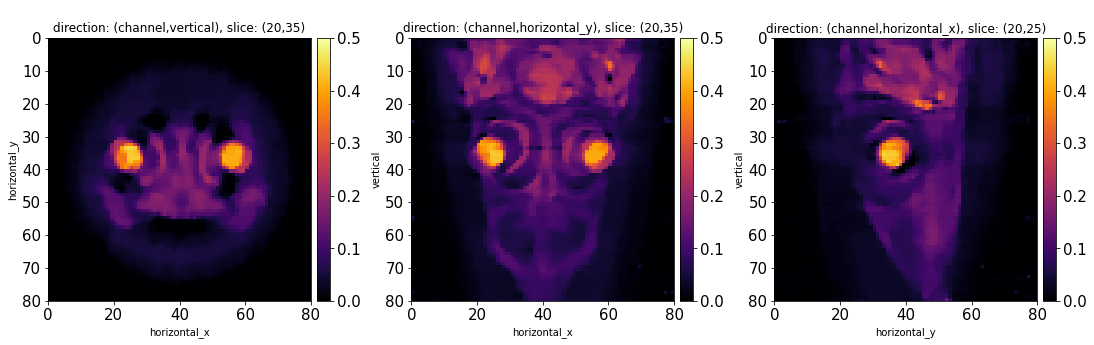

In [51]:
show2D(PDHG_TV_100_SpCh,
       slice_list=[[("channel",20),("vertical",35)],
                   [("channel",20),("horizontal_y",35)],
                   [("channel",20),("horizontal_x",25)]],
                   cmap="inferno", num_cols=3, 
                   origin="upper", fix_range=(0,0.5))

We can directly compare the two types of PDHG reconstruction using `islicer`. Once more, we have provided a 1000 iteration reconstruction of the Space-Channel regularised result as a Nexus file. As you move across energy channels, see if there are any major differences between the constructions.  
 1) PDHG TV using a Spatial correlation for 1000 iterations  
 2) PDHG TV using a Space-Channel correlation for 1000 iterations
 
**Note:** If you wish, you can also compare the 100 iteration results for each method, simply by adding extra lines in the cell below, such as:  
`islicer(PDHG_TV_100_SpCh.get_slice(vertical=35), direction='channel', title = 'Sinogram Channel', cmap='inferno',minmax=(0.0,0.5))`

Look for any differences between the reconstructions as you move across energy channels. For example, do you notice the smoother transition from one channel to the next in our **Space-Channel** reconstructed dataset? This is because the additional spectral regularisation, with its own weighted parameter, helped to reduce noise fluctuations from channel to channel.

In [53]:
reader = NEXUSDataReader(file_name = "/mnt/materials/SIRF/Fully3D/CIL/Lizard/PDHG_TV_1000_Sp_alpha_0.004.nxs")
PDHG_TV_1000_Sp = reader.read()

reader = NEXUSDataReader(file_name = "/mnt/materials/SIRF/Fully3D/CIL/Lizard/PDHG_TV_1000_SpCh_alpha_0.003_beta_0.5.nxs")
PDHG_TV_1000_SpCh = reader.read()

islicer(PDHG_TV_1000_Sp.get_slice(vertical=35), direction='channel', title = 'Channel', cmap='inferno',minmax=(0.0,0.5), origin="upper")
islicer(PDHG_TV_1000_SpCh.get_slice(vertical=35), direction='channel', title = 'Channel', cmap='inferno',minmax=(0.0,0.5),origin="upper")

interactive(children=(IntSlider(value=20, continuous_update=False, description='channel', max=39), FloatRangeS…

interactive(children=(IntSlider(value=20, continuous_update=False, description='channel', max=39), FloatRangeS…

IntSlider(value=20, continuous_update=False, description='channel', max=39)

## Comparison of 4D reconstruction algorithms

In the cell below, we can compare all reconstruction algorithms we have tried so far:
1) FDK  
2) Basic CGLS  
3) CGLS with Tikhonov Regularisation ($\alpha$ = 0.1)  
4) PDHG with Space-Channel Total Variation Regularisation ($\alpha$ = 0.003, $\beta$ = 0.5)

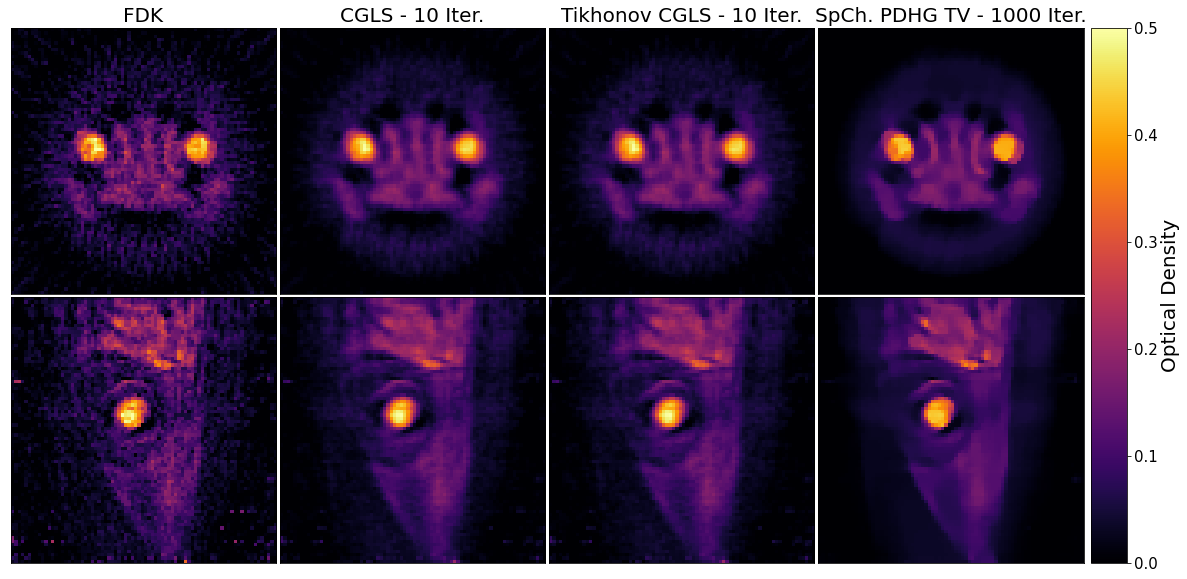

In [54]:
recons = [FBP_recon_4D.get_slice(channel=20, vertical=35), cgls_reg_10.get_slice(channel=20, vertical=35),\
          cgls_reg_10.get_slice(channel=20, vertical=35), PDHG_TV_1000_SpCh.get_slice(channel=20, vertical=35),\
          FBP_recon_4D.get_slice(channel=20, horizontal_x=25), cgls_reg_10.get_slice(channel=20, horizontal_x=25),\
          cgls_reg_10.get_slice(channel=20, horizontal_x=25), PDHG_TV_1000_SpCh.get_slice(channel=20, horizontal_x=25)]

labels_text = ["FDK","CGLS - 10 Iter.","Tikhonov CGLS - 10 Iter.", "SpCh. PDHG TV - 1000 Iter."]

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 14))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 4),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_size = 0.5,
                cbar_pad=0.1
                )

k = 0

for ax in grid:
    im = ax.imshow(recons[k].as_array(), cmap="inferno", vmin = 0.0, vmax = 0.5)   
    
    if k==0:
        ax.set_title(labels_text[0],fontsize=20)
    if k==1:
        ax.set_title(labels_text[1],fontsize=20)  
    if k==2:
        ax.set_title(labels_text[2],fontsize=20)      
    if k==3:
        ax.set_title(labels_text[3],fontsize=20) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

plt.colorbar(im, cax=grid.cbar_axes[0]).set_label(label='Optical Density', size = 20)

# Spatial/Energy Profiles

One way we can directly observe the effect of applying Spatial/Spectral correlation to our algorithms is through the use of pixel profiles across our reconstructed images in each domain respectively.

By plotting signal values across spatial pixels, or across energy channels, the smoothing effects of our regularisation are seen. We will demonstrate each of these below.

## Extracting Spatial Profiles

By identifying a region of our reconstructed slices were the Iodine signals are strong, we can plot along the pixels in this region and compare the line profiles for each algorithm covered here.

Given the strong signals given by the eyes of the lizard head sample, we will look across this pixel row for a single channel, given by slice indices of:
 - `vertical = 35`
 - `horizontal_y = 35`
 - `channel = 20`
 
**Feel free to adjust these values in the cell below if you wish to explore different regions of the reconstructed images.**

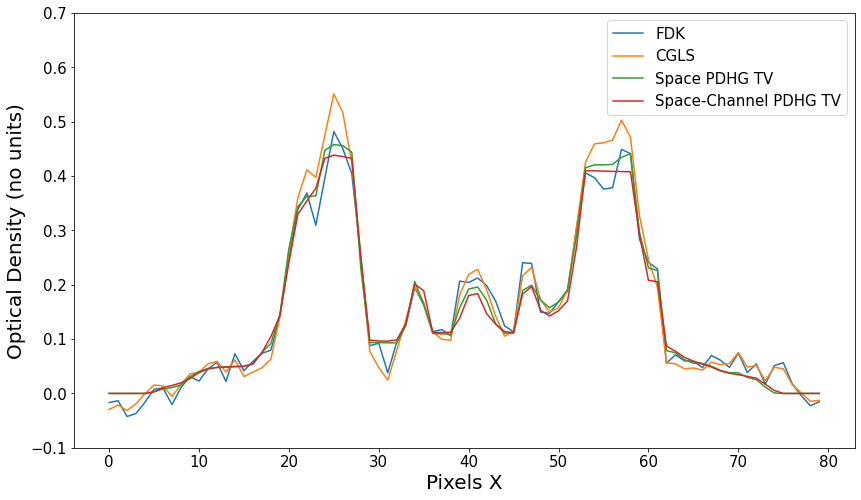

In [55]:
plt.figure(figsize=[14,8])

# Extract line profiles for each algorithm
plt.plot(FBP_recon_4D.get_slice(vertical = 35, horizontal_y = 35, channel = 20).as_array(),label='FDK')
plt.plot(cgls_10.get_slice(vertical = 35, horizontal_y = 35, channel = 20).as_array(),label='CGLS')
plt.plot(PDHG_TV_1000_Sp.get_slice(vertical = 35, horizontal_y = 35, channel = 20).as_array(),label='Space PDHG TV')
plt.plot(PDHG_TV_1000_SpCh.get_slice(vertical = 35, horizontal_y = 35, channel = 20).as_array(),label='Space-Channel PDHG TV')

plt.ylim((-0.1,0.7))
# Label and add key
plt.xlabel('Pixels X', fontsize=20)
plt.ylabel('Optical Density (no units)', fontsize=20)
plt.legend(loc='upper right',fontsize=15)

We can see the reduced noise fluctuations for both PDHG TV reconstructions, compared to the significant noise seen in both FDK and CGLS reconstructions. While the Space-Channel correlation may be overly smoothed, this highlights the impact that a small change in parameter weighting can have on our reconstruction.

## Extracting Energy Profiles

Once we have chosen and optimised our reconstruction routine, we can exploit this additional, energy dimension further by identifying the spectral signals that lie within.

First we can plot out energy profiles for any area within our reconstructed slices. This allows us to find, for instance, an absorption edge.
Iodine has a known absorption 'K-edge' of 33.169 keV, so we can test the accuracy of reconstruction algorithms by seeing where this edge falls in each case. A plot of an idealised, theoretical Iodine K-edge is shown below, occurring precisely at 33.169 keV.  

<img src="Images/Iodine_K_edge.png" width=800 height=800 align="center">
Given that the data will be noisiest for a single voxel, we will extract spectral profiles from one voxel within the eye of the lizard, allowing us to compare the noise level of each reconstruction along the energy axis.

In [56]:
# Select single voxel in lizard eye region

# FDK Recon
fdk_vox = FBP_recon_4D.as_array()[:,35,35,55]

# 3D multi-channel 10 iteration CGLS
cgls_vox = cgls_reg_10.as_array()[:,35,35,55]

# 3D multi-channel space correlated PDHG
pdhg_Sp_vox = PDHG_TV_1000_Sp.as_array()[:,35,35,55]

# 3D multi-channel space-channel correlated PDHG TV
pdhgSpCh_vox = PDHG_TV_1000_SpCh.as_array()[:,35,35,55]

Text(0.5, 0, 'Energy (keV)')

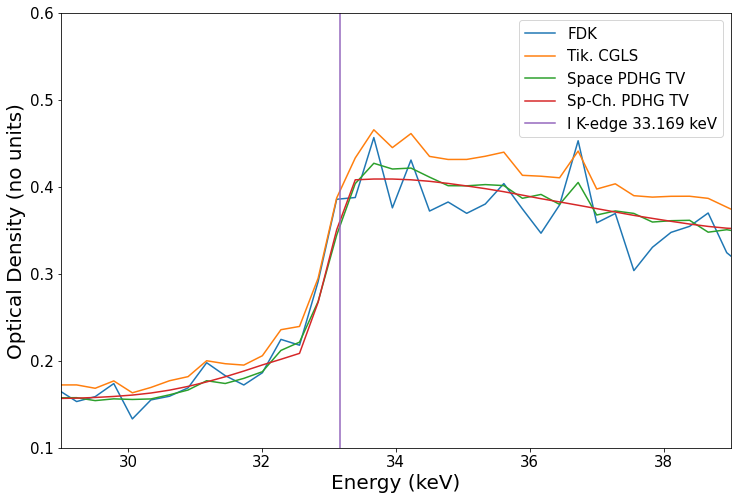

In [57]:
# Set channel numbers for reduced dataset (here 100 to 140)
channel_no = np.linspace(100,140,num_channels)

plt.figure(figsize=(12,8))

plt.plot(ekeV_crop,fdk_vox)
plt.plot(ekeV_crop,cgls_vox) 
plt.plot(ekeV_crop,pdhg_Sp_vox)
plt.plot(ekeV_crop,pdhgSpCh_vox)

plt.plot((33.169,33.169),plt.ylim(0.1,0.6))

plt.legend(labels=['FDK', 'Tik. CGLS', 'Space PDHG TV', 
                   'Sp-Ch. PDHG TV', 'I K-edge 33.169 keV'],fontsize=15)
plt.xlim([29,39])

plt.ylabel('Optical Density (no units)',fontsize=20)
plt.xlabel('Energy (keV)',fontsize=20)

From our plots, we can see all algorithms experience a sharp rise in signal value due to the iodine absorption K-edge. Compared to the theoretical value line, each of the cases match well with the expected position of the edge.
We can very clearly see the impact of the spectral regularisation using PDHG TV, with all noise entirely removed, and an almost perfectly smooth transition across energy channels. We still clearly see the rising edge at the iodine K-edge position. The use of spectral correlation enforces our operator to use the previous energy channel as a reference point for reconstructing data in the next, resulting in a smoother transition across channels.

## Constructing Elemental Maps

Once we know have identified the position of this edge in our energy profile, we can narrow our dataset and produce an 'Iodine map'. That is, we can select only the energy channels occupied by the absorption edge, so all reconstructed signal is now due only to the iodine contrast agent. This method is known as **'K-edge subtraction'**, which you can read about in more detail in papers such as that by [C.K.Egan *et al*, 2015](https://www.nature.com/articles/srep15979#).  
A basic concept is shown below for an energy profile plot. The hashed area highlights the energy range we are interested in, corresponding to the absorption edge.

<img src="Images/K_edge_Sub.jpg" width=800 height=800 align="center">

Based on our plots, we will estimate the start and end of the edge to occur at approximately 32 keV and 34.5 keV respectively.

In [58]:
# Calculate energy channels corresponding to start and end of the K-edge
e_keV = np.array([32,34.5])
# Convert back to channel number based on calibration values 
# (these are specific to the dataset, used here just to show the method.)
channel_no = ((e_keV-0.8575)/0.2786)-100

# Display the channels corresponding to the start and end of the K-edge (within our truncated dataset)
print("Start of edge = channel",int(channel_no[0]))
print("End of edge = channel",int(channel_no[1]))

Start of edge = channel 11
End of edge = channel 20


Now we need to average over all the channels in this channel range for each reconstruction, isolating the signal around the K-edge that only corresponds to Iodine. For simplicity, we will perform this over a single slice, in this case the 25th slice in the `horizontal_x` plane that we have used previously for comparing images.

In [59]:
# 4D FBP
# Sum over all pixels for channels of interest
FBP_chan = np.mean(FBP_recon_4D.as_array()[int(channel_no[0]):int(channel_no[1]),:,:,25],0)

# 4D Tikhonov CGLS
CGLS_Tik_chan = np.mean(cgls_reg_10.as_array()[int(channel_no[0]):int(channel_no[1]),:,:,25],0)

# 4D Space-Channel PDHG TV
PDHG_SpCh_chan = np.mean(PDHG_TV_1000_Sp.as_array()[int(channel_no[0]):int(channel_no[1]),:,:,25],0)

We can use `islicer` once more to compare our results, which shows the iodine maps for each reconstruction. By stacking the results as an array, `islicer` allows you to switch from one reconstruction to the next. You may notice that a lot of the same signal is present to before! This is because the iodine is a high concentration contrast agent which diffuses into nearly all soft tissue structures, increasing the attenuation levels of many areas except the bone regions.

In [60]:
# Collect together iodine maps
stack_maps = (np.array([FBP_chan, CGLS_Tik_chan, PDHG_SpCh_chan]))
titles = ['Simple CGLS', 'Regularised CGLS', 'Space-Channel PDHG TV']
islicer(stack_maps, title=titles, direction=0, cmap='inferno',minmax = (0.0,0.3))

interactive(children=(IntSlider(value=1, continuous_update=False, description='X', max=2), FloatRangeSlider(va…

IntSlider(value=1, continuous_update=False, description='X', max=2)

<h1><center>Conclusions</center></h1>

This notebook focused on bringing together the core elements of the CIL framework you have learned in the previous notebooks, and seeing how these may be applied to a hyperspectral dataset. 

We looked at the key differences in building Image/Acquisition Geometries and Operators for hyperspectral datasets.

We have covered three key algorithms (FDK, CGLS and PDHG) and shown the various ways in which we can build them, both with and without the addition of regularisation terms. We have also explored how each type of regularisation impacts our resulting reconstruction, highlighting why optimisation of our regularisation parameters is so important to produce the highest quality data. This is further highlighted through the extraction of both spatial and spectral profiles, as well as extraction of elemental maps using spectral analyses like K-edge subtraction. For more information on hyperspectral tomography reconstruction we refer to [Warr et al](https://arxiv.org/pdf/2103.04796), [Ametova et al](https://iopscience.iop.org/article/10.1088/1361-6463/ac02f9/pdf) and [Papoutsellis et al](https://arxiv.org/pdf/2102.06126).

**Click the link below to see the potential for full volume, white-beam reconstructions using both CGLS (Left) and PDHG TV (Right)**  
[4D Lizard Full Volume Reconstruction](Images/Lizard_gif.gif "segment")